# Process the output of the simulation

(This can be required if the sensitivity curve does not form a single connected (but possibly open) path.)

List the currently-installed packages (for reproducibility).

In [1]:
]st

Status `~/Documents/Research/Projects/SensCalc/Code/SensMC/Project.toml`
  [864edb3b] DataStructures v0.18.13
⌃ [31c24e10] Distributions v0.25.86
⌃ [e9467ef8] GLMakie v0.8.2
⌃ [5c1252a2] GeometryBasics v0.4.6
  [7073ff75] IJulia v1.24.0
⌃ [682c06a0] JSON v0.21.3
  [3f54b04b] LorentzVectors v0.4.3
  [ea0cff06] MDBM v0.1.6 `https://github.com/JLTastet/MDBM.jl#3788144`
⌅ [ee78f7c6] Makie v0.19.2
  [c03570c3] Memoize v0.4.4
  [e1d29d7a] Missings v1.1.0
  [3b2b4ff1] Multisets v0.4.4
⌃ [bac558e1] OrderedCollections v1.4.1
  [c46f51b8] ProfileView v1.7.1
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
⌃ [f2b01f46] Roots v2.0.10
⌃ [90137ffa] StaticArrays v1.5.18
⌅ [2913bbd2] StatsBase v0.33.21
  [8ba89e20] Distributed
  [37e2e46d] LinearAlgebra
  [1a1011a3] SharedArrays
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


Include the snapshots of the relevant scripts (once again for reproducibility).

In [2]:
include("$(@__DIR__)/../lib/IncludeAll.jl");
include("$(@__DIR__)/../scripts/GenerateEvents.jl");
include("$(@__DIR__)/../scripts/ScanSensitivity.jl");

  Activating project at `~/Documents/Research/Projects/SensCalc/Code/SensMC`


In [3]:
data_dir = "$(@__DIR__)/../tables/sensitivity/SHiP";

In [4]:
using DataFrames
using CSV
using Printf
using PyPlot
PyPlot.svg(true)
using Random
Random.seed!(19694);

In [5]:
function read_sensitivity(root, name)
    df_sol = CSV.read(joinpath(root, "$(name).csv"), DataFrame)
    df_ct  = CSV.read(joinpath(root, "$(name)_connection.csv"), DataFrame)
    edges = tuple.(df_ct[:,1], df_ct[:,2]);
    open_loops, closed_loops = find_loops(edges)
    curves = [(df_sol[perm,1], df_sol[perm,2]) for perm in vcat(open_loops, closed_loops)]
end

read_sensitivity (generic function with 1 method)

Plot the sensitivity along with the one obtained by Maksym, as a last cross-check.

In [6]:
function make_plot(; title="", xlabel=L"m_S\;[\mathrm{GeV}]", ylabel=L"\theta^2", figsize=(6.4, 4.8), grid=true)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_yscale("log")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);
    if grid
        ax.grid(color="gray", linestyle=":")
    end
    ax.autoscale()
    ax.set_title(title, fontsize=10)
    fig, ax
end

make_plot (generic function with 1 method)

In [7]:
function plot_sensitivity!(ax, root, name; label="", square=false, style...)
    curves = read_sensitivity(root, name)
    xs, ys = [], []
    for (i, curve) in enumerate(curves)
        lb = if i == 1; label else; "" end
        x, y = curve
        y = square ? y .^2 : y
        ax.plot(x, y, label=lb; style...)
        push!(xs, x)
        push!(ys, y)
    end
    xs, ys
end

plot_sensitivity! (generic function with 1 method)

In [8]:
function plot_reference_sensitivity!(ax, root, name;
        header=["mS", "signal_scale"], square=false, linewidth=1, style...)
    df = CSV.read(joinpath(root, name), DataFrame, header=header)
    y = square ? df[:,2] .^2 : df[:,2]
    ax.plot(df[:,1], y; linewidth=linewidth, style...)
end

plot_reference_sensitivity! (generic function with 1 method)

In [9]:
function plot_excluded_region!(ax, root, name;
        header=["mS", "signal_scale"], square=false, linewidth=1, style...)
    df = CSV.read(joinpath(root, name), DataFrame, header=header)
    y = square ? df[:,2] .^2 : df[:,2]
    ax.plot(df[:,1], y; color="black", linewidth=linewidth, style...)
    ax.fill(df[:,1], y; color="lightgrey", style...)
end

plot_excluded_region! (generic function with 1 method)

#### Plot the sensitivity

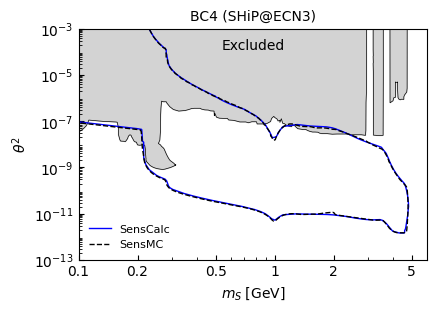

In [10]:
fig, ax = make_plot(title="BC4 (SHiP@ECN3)", figsize=(4.5,3), grid=false)
plot_excluded_region!(ax, joinpath(data_dir, ".."), "scalar-all-experiments.txt"; header=["mS", "theta"], linewidth=0.5)
plot_reference_sensitivity!(ax, data_dir, "Sensitivity_Scalar_at_SHiP_BrhToSS=0._Nev=2.3.dat"; header=["mS", "theta"], label="SensCalc", color="blue")
#plot_reference_sensitivity!(ax, data_dir, "BC4-sensitivity-SHiP.txt"; header=["mS", "theta"], label="SHADOWS LoI", color="brown")
mS, θ² = plot_sensitivity!(ax, data_dir, "SHiP_scalar_sensitivity_CL90", label="SensMC", color="black", linestyle="--", square=true, linewidth=1)
ax.set_xscale("log")
ax.autoscale()
ax.set_xlim(left=0.1, right=6)
ax.set_ylim(top=1e-3, bottom=1e-13)
xticks = [0.1, 0.2, 0.5, 1, 2, 5]
ax.set_xticks(xticks)
ax.set_xticklabels([@sprintf("%.1g", x) for x in xticks])
ax.legend(loc="lower left", frameon=false, fontsize=8)
ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))
ax.tick_params(axis="both", which="both", direction="in")
#ax.text(0.83, 0.61, "CL = 0.9", fontsize=15, transform=ax.transAxes, ha="center", va="top")
ax.text(0.5, 0.96, "Excluded", fontsize=10, transform=ax.transAxes, ha="center", va="top")
nothing

In [11]:
fig.savefig("$(@__DIR__)/../plots/SHiP_scalar_sensitivity_CL90.pdf", bbox_inches="tight")

#### Process and save the actual sensitivity curve

Extract the relevant loop(s).

In [12]:
mS

1-element Vector{Any}:
 [0.10308128398620305, 0.10519389358603679, 0.10734915298318042, 0.10954720866666724, 0.11179191471202109, 0.11408188687243824, 0.11423894040478552, 0.11657930122618686, 0.11896995140797045, 0.12140380062161883  …  0.22616811703706236, 0.22463028154317408, 0.2233278112159625, 0.2217588202704574, 0.2201403292705911, 0.21912850892764274, 0.2190238681946765, 0.21781504275646477, 0.215975416756221, 0.21478583117778455]

The array looks well connected, so let’s save it without further processing.

In [13]:
@assert length(mS) == 1
@assert length(θ²) == 1

In [14]:
mS[1]

475-element Vector{Float64}:
 0.10308128398620305
 0.10519389358603679
 0.10734915298318042
 0.10954720866666724
 0.11179191471202109
 0.11408188687243824
 0.11423894040478552
 0.11657930122618686
 0.11896995140797045
 0.12140380062161883
 0.12389398116019745
 0.12643100012963854
 0.12902071894419612
 ⋮
 0.2300669853642768
 0.22814222775744758
 0.22616811703706236
 0.22463028154317408
 0.2233278112159625
 0.2217588202704574
 0.2201403292705911
 0.21912850892764274
 0.2190238681946765
 0.21781504275646477
 0.215975416756221
 0.21478583117778455

Create a data frame containing the curve.

In [15]:
df = DataFrame(mS = mS[1], theta2 = θ²[1])

Row,mS,theta2
,Float64,Float64
1,0.103081,8.2887e-8
2,0.105194,8.12617e-8
3,0.107349,7.97034e-8
4,0.109547,7.81361e-8
5,0.111792,7.65533e-8
6,0.114082,7.50298e-8
7,0.114239,7.4931e-8
8,0.116579,7.34532e-8
9,0.11897,7.19795e-8


Let’s check that it plots correctly.

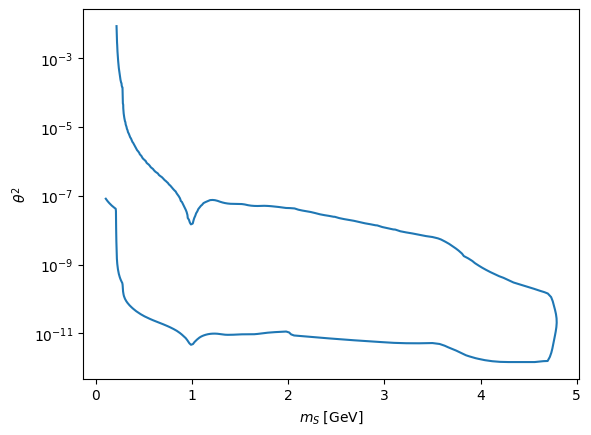

In [16]:
plt.plot(df.mS, df.theta2)
plt.yscale("log")
plt.xlabel(raw"$m_S\;[\mathrm{GeV}]$")
plt.ylabel(raw"$\theta^2$");

Looks good. Let’s save the final curve.

In [17]:
CSV.write(joinpath(data_dir, "SHiP_scalar_sensitivity_curve_CL90.csv"), df)

"/Users/jl/Documents/Research/Projects/SensCalc/Code/SensMC/notebooks/../tables/sensitivity/SHiP/SHiP_scalar_sensitivity_curve_CL90.csv"